In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

%matplotlib inline

In [2]:
df = pd.read_csv('data/samples.csv')

In [31]:
df['number_of_words_of_title'] = df['title'].str.split().str.len()

Text(0.5, 0, 'Price (log)')

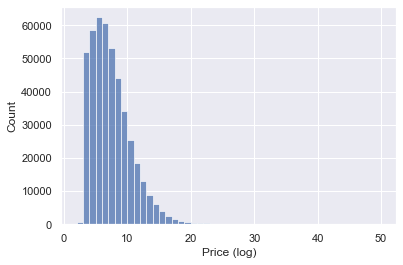

In [71]:
fig = sns.histplot(data=df, x='number_of_words_of_title', kde=False, stat='count', binwidth=1)
fig.set_xlabel('Price (log)')
#fig.get_figure().savefig('figures/price_kde_histogram.jpg', dpi=500)

In [78]:
df['title'].str.split().str.len().describe(percentiles=[0.1])

count    450000.000000
mean          6.951033
std           3.269366
min           2.000000
10%           3.000000
50%           6.000000
max          50.000000
Name: title, dtype: float64

In [24]:
df['body'].str.split().str.len().mean()

73.07244888888889

In [79]:
df['title'].str.split().str.len()

AttributeError: 'Series' object has no attribute 'percentile'